In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import os, re
import nltk
BASE_DIR = '../input/'
LABELED_TRAIN_DF = BASE_DIR + 'labeled_train_clean_reviews.csv'
TEST_DF = BASE_DIR + 'test_clean_reviews.csv'

In [2]:
labeled_train = pd.read_csv(LABELED_TRAIN_DF, header = 0)
test = pd.read_csv(TEST_DF, header = 0)
labeled_train["review"] = labeled_train["review"].astype(str)
test["review"] = test["review"].astype(str)
print "Read %d labeled train reviews" \
          "and %d test reviews" % (labeled_train["review"].size, test["review"].size)

Read 25000 labeled train reviewsand 25000 test reviews


Data leakage

Check if test["sentiment"] is correct

In [3]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

In [4]:
import fastText
EMBEDDING_DIM = 300  # Word vector dimensionality
fasttext_model = fastText.load_model("../input/fasttext_300features_40minwords_10context.bin")

Prepare

In [5]:
train_clean_reviews = labeled_train["review"].tolist()
test_clean_reviews = test["review"].tolist()

all_clean_reviews = train_clean_reviews + test_clean_reviews

In [6]:
print(np.random.choice(all_clean_reviews, 1))

['you don t need to write a script for this trashed outrage  you just sit back and watch a pair of moonshine women and guests duke each other out before a riotous audience exposure at   the jerry show    violent and obnoxious  this cash in on the real jerry springer program reveals everything that the over rated hyped talk show doesn t show to you on the air     unless you have a collection of uncensored videos made by the producers of   cops    even the outside world of springerland reveals the most amateurish acting of the decade  this goes to show you that the gong show movie had a central character in a motion picture turkey  change the channel  rejected']


In [7]:
# We vectorize the text corpus by turning each text into a sequence of integers
# Each integer is the index of a token in the dictionary
from keras.preprocessing.text import Tokenizer

MAX_NUM_WORDS_FOR_KERAS_TOKENIZER = 200000
#
# num_words: the maximum number of words to keep, based on frequency.
keras_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS_FOR_KERAS_TOKENIZER)
#
# fit_on_texts accepts a list of strings, a generator of strings or 
# a list of list of strings. In the last case, it assumes each entry of the lists to be a token.
# Here we provide a list of strings.
keras_tokenizer.fit_on_texts(all_clean_reviews)
word_index = keras_tokenizer.word_index
print('Keras Tokenizer found %s unique tokens' % len(word_index))
#
# texts_to_sequences transforms each text in texts to a sequence of integers.
train_sequences = keras_tokenizer.texts_to_sequences(train_clean_reviews)
test_sequences = keras_tokenizer.texts_to_sequences(test_clean_reviews)

Using TensorFlow backend.


Keras Tokenizer found 101376 unique tokens


In [8]:
# We pad all text sequences to the same length.
# By default zeros are padded at the front.
from keras.preprocessing.sequence import pad_sequences

# Set max length for each review sequence.
MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN = 500

train_pad_sequences = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)
test_pad_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN)

In [9]:
print(word_index.items()[0])

('fawn', 29637)


In [10]:
# Prepare word embedding matrix

# Choose the smaller number of the two as column length of the matrix
num_words = min(MAX_NUM_WORDS_FOR_KERAS_TOKENIZER, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_matrix[i] = fasttext_model.get_word_vector(word)
# Null word embeddings are words that don't exist in the embedding matrix
# and are therefore represented as zero vectors.
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
# Null word embeddings is one because index 0 does not match any tokens. keras tokenizer uses 1-based index.

Null word embeddings: 1


In [11]:
# Split train_sequences into train and validation. Ratio: 80/20
VALIDATION_SPLIT = 0.2
np.random.seed(1234)

# 
perm = np.random.permutation(len(train_sequences))
index_train = perm[:int(len(train_sequences)*(1-VALIDATION_SPLIT))]
index_val = perm[int(len(train_sequences)*(1-VALIDATION_SPLIT)):]

x_train = train_pad_sequences[index_train]
x_val = train_pad_sequences[index_val]
y_train = labeled_train["sentiment"][index_train].tolist()
y_val = labeled_train["sentiment"][index_val].tolist()

print('Randomly split %d pad sequences for training, %d for validation' % (len(x_train) ,len(x_val)))


Randomly split 20000 pad sequences for training, 5000 for validation


In [12]:
x_test = test_pad_sequences
y_test = test["sentiment"]

## Model Architecture

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, Conv1D, MaxPooling1D ,GlobalMaxPooling1D
from keras.initializers import Constant

In [14]:
def cnn_rnn_model(dropout_cnn=0.8, dropout_rnn=0.2, num_filters=64, kernel_size=2):
    model = Sequential()
    
    LSTM_UNITS = 32
    LSTM_DROPOUT = 0.
    LSTM_RECCURENT_DROPOUT = 0.

    embedding_layer = Embedding(
            num_words,
            EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH_FOR_KERAS_RNN,
            trainable=False)
    output_layer = Dense(1, activation='sigmoid')
    
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=1))
    # Cannot use GlobalMaxPooling since you're feeding it into RNN
    model.add(MaxPooling1D(2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_cnn))
    model.add(Bidirectional(LSTM(LSTM_UNITS, 
                                 dropout=LSTM_DROPOUT, 
                                 recurrent_dropout=LSTM_RECCURENT_DROPOUT
                                )))
    model.add(Dropout(dropout_rnn))
    model.add(output_layer)
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [15]:
model = cnn_rnn_model()

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          30413100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 499, 64)           38464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 249, 64)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 249, 32)           2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 249, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [17]:
# batch_size: number of samples per gradient update
model.fit(x_train, y_train, batch_size=64, epochs=12, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/12
20000/20000 [==============================] - 286s 14ms/step - loss: 0.5027 - acc: 0.7467 - val_loss: 0.3395 - val_acc: 0.8652
Epoch 2/12
20000/20000 [==============================] - 282s 14ms/step - loss: 0.3485 - acc: 0.8565 - val_loss: 0.2891 - val_acc: 0.8824
Epoch 3/12
20000/20000 [==============================] - 283s 14ms/step - loss: 0.3186 - acc: 0.8681 - val_loss: 0.2938 - val_acc: 0.8812
Epoch 4/12
20000/20000 [==============================] - 286s 14ms/step - loss: 0.3065 - acc: 0.8770 - val_loss: 0.3050 - val_acc: 0.8876
Epoch 5/12
20000/20000 [==============================] - 283s 14ms/step - loss: 0.2860 - acc: 0.8863 - val_loss: 0.2887 - val_acc: 0.8874
Epoch 6/12
20000/20000 [==============================] - 282s 14ms/step - loss: 0.2715 - acc: 0.8909 - val_loss: 0.2794 - val_acc: 0.8894
Epoch 7/12
20000/20000 [==============================] - 282s 14ms/step - loss: 0.2638 - acc: 0.8958 - val_loss: 0.2

In [18]:
y_test_pred = model.predict(x_test)

In [19]:
y_test_pred_binary = map(lambda predict: 1 if predict > 0.5 else 0, y_test_pred)

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [21]:
print("The AUC score for CNN-BiLSTM model is : %.5f." %roc_auc_score(y_test, y_test_pred_binary))

The AUC score for CNN-BiLSTM model is : 0.90248.


In [22]:
# Write the test results
output = pd.DataFrame(data={"id": test["id"], "sentiment": y_test_pred_binary})
output.to_csv(os.path.join('../', 'output', "cnn_bilstm_fasttext_8dropout_12epoch.csv"), index=False, quoting=3)
print "Wrote to cnn_bilstm_fasttext_8dropout_12epoch.csv"

Wrote to cnn_bilstm_fasttext_8dropout_12epoch.csv


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

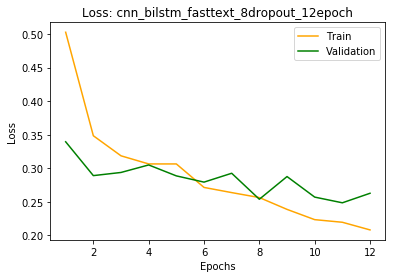

In [2]:
loss = [0.5027, 0.3485, 0.3186, 0.3065, 0.3065, 0.2715, 0.2638, 0.2564, 0.2388, 0.2235, 0.2196, 0.2082]
val_loss = [0.3395, 0.2891, 0.2938, 0.3050, 0.2887, 0.2794, 0.2926, 0.2539, 0.2877, 0.2571, 0.2486, 0.2628]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, color='orange', label='Train')
plt.plot(epochs, val_loss, color='green', label='Validation')
plt.title('Loss: cnn_bilstm_fasttext_8dropout_12epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../figures/cnn_bilstm_fasttext_8dropout_12epoch_loss.png', dpi=900)

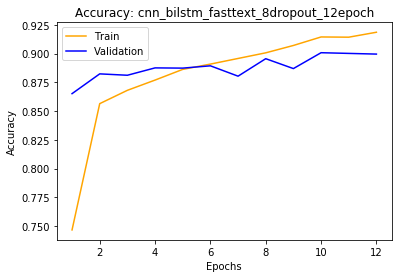

In [3]:
acc = [0.7467, 0.8565, 0.8681, 0.8770, 0.8863, 0.8909, 0.8958, 0.9007, 0.9071, 0.9145, 0.9143, 0.9186]
val_acc = [0.8652, 0.8824, 0.8812, 0.8876, 0.8874, 0.8894, 0.8804, 0.8956, 0.8870, 0.9008, 0.9002, 0.8996]

plt.plot(epochs, acc, color='orange', label='Train')
plt.plot(epochs, val_acc, color='blue', label='Validation')
plt.title('Accuracy: cnn_bilstm_fasttext_8dropout_12epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../figures/cnn_bilstm_fasttext_8dropout_12epoch_accuracy.png', dpi=900)